# Capstone Part 5 - Demo
___
## Setup
Note: You will need to install the LibROSA package (https://librosa.github.io/librosa/) and the Python-sounddevice package (https://python-sounddevice.readthedocs.io/en/0.3.14/) by entering `conda install -c conda-forge librosa python-sounddevice` in Anaconda Prompt or the command line of your choice. You may wish to create a virtual Conda environment dedicated to these packages to avoid running into any dependency issues.

In [1]:
# Basic packages
import numpy as np
import pandas as pd

# Loading in the dataframe I made for the demo
demo_df = pd.read_csv('demo.csv')

# For playing audio files in this notebook
from IPython.display import Audio

# For audio analysis
import librosa
import librosa.display

# For visualizations
import matplotlib.pyplot as plt
%matplotlib inline

# For loading in the models I pickled in part 2b
import joblib

# Loading in the gender classifier
gender_logreg = joblib.load('pickle1_gender_logreg.pkl')

# Loading in the male emotion classifiers
male_emotion_logreg = joblib.load('pickle2_male_emotion_logreg.pkl')
male_emotion_svm = joblib.load('pickle3_male_emotion_svm.pkl')

# Loading in the female emotion classifiers
female_emotion_logreg = joblib.load('pickle4_female_emotion_logreg.pkl')
female_emotion_svm = joblib.load('pickle5_female_emotion_svm.pkl')

# For recording audio
import sounddevice as sd

# Setting defaults for recording audio
sample_rate = 22050
sd.default.samplerate = sample_rate
sd.default.channels = 1

# Checking what devices are in use
sd.query_devices()

  0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
> 1 Krisp Microphone (Krisp), MME (2 in, 0 out)
  2 Microphone (Conexant SmartAudio, MME (2 in, 0 out)
  3 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
< 4 Speakers (Conexant SmartAudio H, MME (0 in, 2 out)
  5 Krisp Speaker (Krisp), MME (0 in, 2 out)

Note: I used a noise cancellation software called _Krisp_ for the demo.

I will now create two functions:
- The first is to show how my models perform on the data they were trained and tested on. I did not have the foresight to save just the test sets for the demo csv file, so this is not ideal and is just for demonstration purposes.
- The second takes in a guest's voice recording, creates visualizations, and predicts the guest's gender and emotion.

In [2]:
def ravdess_demo():
    # Pick a sample from demo_df and assign a variable to it
    sample = demo_df.sample(1)

    # Listen to the clip
    print('Listen to the clip:')
    path = sample['Path'].values[0]
    display(Audio(filename=path))
    
    print('________________________________________________________________________________')
    print()
    
    # Load in the first 3 seconds of the clip
    y, sr = librosa.load(path=path, duration=3)
    
    # Visualize the sound wave
    plt.figure(figsize=(10, 5))
    librosa.display.waveplot(y=y)
    plt.title('Sound wave', fontsize=15)
    plt.show()
    
    print('________________________________________________________________________________')
    print()
        
    # Mel spectrogram
    mel = librosa.feature.melspectrogram(y)
    mel_db = librosa.power_to_db(mel)
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(data=mel_db, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram', fontsize=15)
    plt.show()
    
    print('________________________________________________________________________________')
    print()

    # Mel-frequency cepstrum
    mfccs = librosa.feature.mfcc(y)
    plt.figure(figsize = (10, 5))
    librosa.display.specshow(data=mfccs, x_axis='time')
    plt.colorbar()
    plt.title('Mel-frequency cepstrum', fontsize=15)    
    plt.show()
    
    print('________________________________________________________________________________')
    print()
    
    # Examine some of the mel-frequency cepstrum coefficients
    print('Mel-frequency cepstrum coefficients:')
    display(pd.DataFrame(mfccs))
    
    print('________________________________________________________________________________')
    print()
    
    # Predict the gender
    mfccs_reshaped = mfccs.reshape(1, -1)
    predicted_gender = gender_logreg.predict(mfccs_reshaped)[0]
    print(f'The gender classification model predicts that this person is {predicted_gender}.')
    
    # Ask the user if the prediction seems correct
    print('Does this prediction seem correct? Please enter either "yes" or "no".')
    user_input = input()
    while user_input not in ['yes', 'no']:
        print('Try again! Please enter either "yes" or "no".')
        user_input = input()
        
    # If yes, predict the emotion using the emotion classifiers for the corresponding gender
    if user_input == 'yes':
        
        if predicted_gender == 'male':
            print(f'The first male emotion classification model predicts that this man is feeling {male_emotion_logreg.predict(mfccs_reshaped)[0]}.')
            print(f'The second male emotion classification model predicts that this man is feeling {male_emotion_svm.predict(mfccs_reshaped)[0]}.')
        
        else: # so if 'female'
            print(f'The first female emotion classification model predicts that this woman is feeling {female_emotion_logreg.predict(mfccs_reshaped)[0]}.')
            print(f'The second female emotion classification model predicts that this woman is feeling {female_emotion_svm.predict(mfccs_reshaped)[0]}.')
            
    # If no, predict the emotion using the emotion classifiers for both genders
    else:
        print('Oops! In that case, are any of these emotion predictions correct?')
        print(f'The first male emotion classification model predicts that this person is feeling {male_emotion_logreg.predict(mfccs_reshaped)[0]}.')
        print(f'The second male emotion classification model predicts that this person is feeling {male_emotion_svm.predict(mfccs_reshaped)[0]}.')
        print(f'The first female emotion classification model predicts that this person is feeling {female_emotion_logreg.predict(mfccs_reshaped)[0]}.')
        print(f'The second female emotion classification model predicts that this person is feeling {female_emotion_svm.predict(mfccs_reshaped)[0]}.')
    
    print('________________________________________________________________________________')
    print()
    
    # Print some info about the sample
    print("Here are the clip's actual gender and emotion:")
    print('Gender:', sample['Gender'].values[0])
    print('Emotion:', sample['Emotion'].values[0])
    print('Intensity:', sample['Intensity'].values[0])
#     print(f'Duration: {np.round(sample["Duration"].values[0], 2)} sec')

#     if sample['Statement'].values[0] == 'kids':
#         print('Statement: "Kids are talking by the door."')
#     else:
#         print('Statement: "Dogs are sitting by the door."')

In [3]:
def guest_demo():
    # Record audio
    print('*Recording audio...*')
    guest_recording = sd.rec(frames=(3*sample_rate))
    sd.wait()
    print('Finished recording!')
    
    print('________________________________________________________________________________')
    print()
    
    # Listen to the clip
    print('Listen to the clip:')
    guest_recording_reshaped = guest_recording.reshape(66150)
    display(Audio(data=guest_recording_reshaped, rate=22050))
    
    print('________________________________________________________________________________')
    print()

    # Visualize the sound wave
    plt.figure(figsize=(10, 5))
    librosa.display.waveplot(y=guest_recording_reshaped)
    plt.title('Sound wave', fontsize=15)
    plt.show()
    
    print('________________________________________________________________________________')
    print()
        
    # Mel spectrogram
    mel = librosa.feature.melspectrogram(guest_recording_reshaped)
    mel_db = librosa.power_to_db(mel)
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(data=mel_db, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram', fontsize=15)
    plt.show()
    
    print('________________________________________________________________________________')
    print()

    # Mel-frequency cepstrum
    mfccs = librosa.feature.mfcc(guest_recording_reshaped)
    plt.figure(figsize = (10, 5))
    librosa.display.specshow(data=mfccs, x_axis='time')
    plt.colorbar()
    plt.title('Mel-frequency cepstrum', fontsize=15)
    plt.show()
    
    print('________________________________________________________________________________')
    print()
    
    # Examine some of the mel-frequency cepstrum coefficients
    print('Mel-frequency cepstrum coefficients:')
    display(pd.DataFrame(mfccs))
    
    print('________________________________________________________________________________')
    print()
    
    # Predict the gender
    mfccs_reshaped = mfccs.reshape(1, -1)
    predicted_gender = gender_logreg.predict(mfccs_reshaped)[0]
    print(f'The gender classification model predicts that you are {predicted_gender}.')
    
    # Ask the user if the prediction is correct
    print('Is this prediction correct? Please enter either "yes" or "no".')
    user_input = input()
    while user_input not in ['yes', 'no']:
        print('Try again! Please enter either "yes" or "no".')
        user_input = input()
        
    # If yes, predict the emotion using the emotion classifiers for the corresponding gender
    if user_input == 'yes':
        
        if predicted_gender == 'male':
            print(f'The first male emotion classification model predicts that you are feeling {male_emotion_logreg.predict(mfccs_reshaped)[0]}.')
            print(f'The second male emotion classification model predicts that you are feeling {male_emotion_svm.predict(mfccs_reshaped)[0]}.')
        
        else: # so if 'female'
            print(f'The first female emotion classification model predicts that you are feeling {female_emotion_logreg.predict(mfccs_reshaped)[0]}.')
            print(f'The second female emotion classification model predicts that you are feeling {female_emotion_svm.predict(mfccs_reshaped)[0]}.')

    # If no, predict the emotion using the emotion classifiers for both genders
    else:
        print('Oops, sorry! In that case, are any of these emotion predictions correct?')
        print(f'The first male emotion classification model predicts that you are feeling {male_emotion_logreg.predict(mfccs_reshaped)[0]}.')
        print(f'The second male emotion classification model predicts that you are feeling {male_emotion_svm.predict(mfccs_reshaped)[0]}.')
        print(f'The first female emotion classification model predicts that you are feeling {female_emotion_logreg.predict(mfccs_reshaped)[0]}.')
        print(f'The second female emotion classification model predicts that you are feeling {female_emotion_svm.predict(mfccs_reshaped)[0]}.')

___
# Demo

Listen to the clip:


________________________________________________________________________________



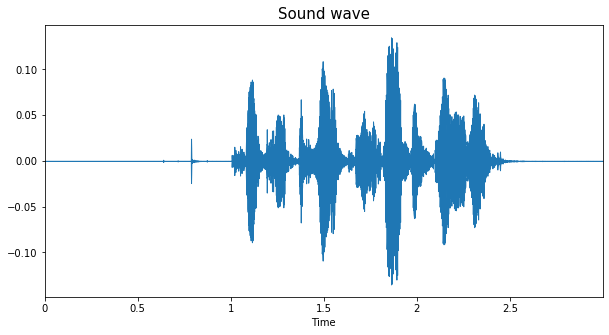

________________________________________________________________________________



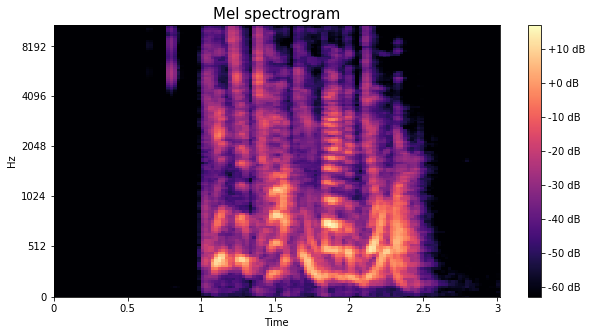

________________________________________________________________________________



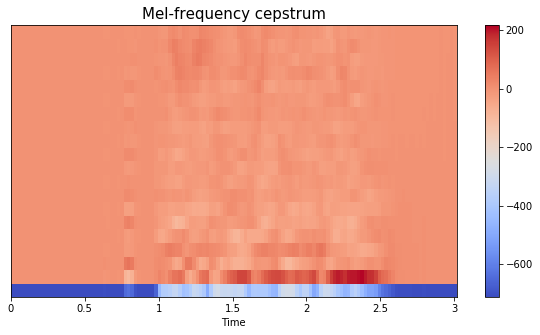

________________________________________________________________________________

Mel-frequency cepstrum coefficients:


,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
0,-711.651226,-711.651226,-711.651226,-711.651226,-711.651226,-711.651226,-711.651226,-711.651226,-711.651226,-711.651226,...,-707.443697,-709.343248,-710.068576,-710.357984,-711.534780,-711.651226,-711.243134,-711.530006,-711.564742,-709.876998
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.964617,3.103647,2.224004,1.812906,0.163181,0.000000,0.566674,0.170387,0.121563,2.479757
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.597934,2.844461,2.181608,1.765223,0.158714,0.000000,0.535725,0.167266,0.119336,2.393514
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.922779,2.779859,2.111639,1.686950,0.151359,0.000000,0.485522,0.162107,0.115656,2.255847
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.981593,2.784773,2.015120,1.579856,0.141250,0.000000,0.418071,0.154972,0.110565,2.075012
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.426285,2.531718,1.893461,1.446347,0.128571,0.000000,0.336069,0.145949,0.104128,1.861006
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.521346,2.049418,1.748436,1.289409,0.113553,0.000000,0.242784,0.135147,0.096421,1.624330
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.711090,1.683936,1.582153,1.112523,0.096469,0.000000,0.141928,0.122699,0.087540,1.374789
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.490329,1.527401,1.397018,0.919581,0.077629,0.000000,0.037501,0.108755,0.077592,1.120530
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.592133,1.275019,1.195702,0.714778,0.057377,0.000000,-0.066372,0.093486,0.066698,0.867462


________________________________________________________________________________

The gender classification model predicts that this person is female.
Does this prediction seem correct? Please enter either "yes" or "no".


 yes


The first female emotion classification model predicts that this woman is feeling surprised.
The second female emotion classification model predicts that this woman is feeling surprised.
________________________________________________________________________________

Here are the clip's actual gender and emotion:
Gender: female
Emotion: surprised
Intensity: normal


In [4]:
ravdess_demo()

*Recording audio...*
Finished recording!
________________________________________________________________________________

Listen to the clip:


________________________________________________________________________________



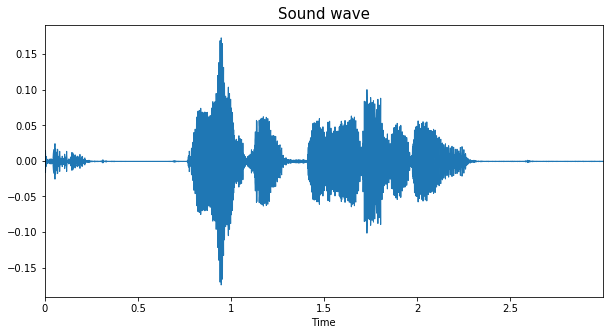

________________________________________________________________________________



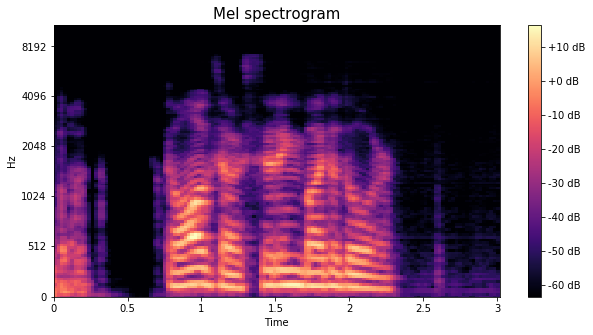

________________________________________________________________________________



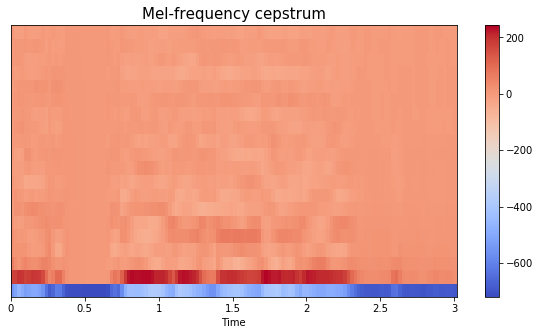

________________________________________________________________________________

Mel-frequency cepstrum coefficients:


,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
0,-546.265782,-509.331987,-465.387681,-496.921109,-530.335916,-514.505220,-498.468406,-500.288145,-517.615155,-560.843894,...,-700.782781,-694.767128,-690.439835,-685.090995,-684.867412,-690.928153,-690.713273,-686.415390,-688.703760,-694.529599
1,173.194456,177.149917,197.874041,193.456125,176.354121,180.903226,192.066728,189.554769,184.283552,162.938200,...,24.903493,30.578270,34.722332,41.722517,40.996262,34.785295,35.531066,38.769204,35.227189,29.445125
2,59.850317,30.385170,15.281183,38.553414,50.918288,34.236457,29.359130,28.538078,37.474327,54.479839,...,20.742930,21.128884,21.952326,26.742914,25.199955,23.389197,25.014100,23.829097,20.637204,18.380192
3,24.543794,17.514602,15.639310,15.468836,15.914193,1.134465,-7.566692,-3.205280,-2.252509,1.709079,...,16.007861,13.904339,12.812909,14.807154,15.006690,15.715053,16.312195,15.437788,13.878005,12.749742
4,27.641133,8.760060,2.912128,5.359568,1.115378,-6.926500,-10.387446,-0.573245,4.638109,7.329359,...,12.016576,11.110446,9.997098,10.019732,12.501889,13.508794,11.570722,13.752546,13.490861,12.808028
5,12.810203,-1.619715,-10.712747,-4.760567,5.614512,4.178153,9.847758,17.029367,20.304719,27.837657,...,8.984436,9.820558,9.454037,8.161392,10.938141,11.429337,9.047525,11.840419,12.168661,11.957338
6,3.827696,21.107358,18.853958,11.773994,26.894963,32.583344,38.714867,36.130049,29.607114,26.641891,...,6.742219,7.463512,6.418918,4.754402,6.464713,6.109599,5.667773,7.958613,8.603459,8.184689
7,8.603831,15.395439,4.931686,0.743779,-5.164220,-1.125829,0.337489,-5.165312,-3.286265,-2.590283,...,5.383399,4.641205,2.647864,1.342279,2.086256,1.036104,3.063658,5.125077,5.248458,5.090152
8,4.346317,-1.082552,-9.294758,-11.800550,-32.039940,-29.969737,-29.339938,-30.419099,-25.533963,-20.217775,...,4.968100,3.223291,1.347235,1.291247,1.270585,0.269977,2.523001,4.379191,3.475788,5.094102
9,-2.305430,-6.123858,-7.307139,-8.129761,2.222887,6.707176,-4.021252,-5.387577,-5.980100,-5.076240,...,4.979954,3.413445,2.293062,3.742132,3.285597,2.567053,2.966996,5.447836,4.613222,6.853095


________________________________________________________________________________

The gender classification model predicts that you are male.
Is this prediction correct? Please enter either "yes" or "no".


 yes


The first male emotion classification model predicts that you are feeling happy.
The second male emotion classification model predicts that you are feeling disgusted.


In [5]:
guest_demo()